In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, GlobalAveragePooling2D, Flatten, Dropout, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical

import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
import albumentations as A
import cv2
from glob import glob
from tqdm import tqdm
import numpy as np

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
! kaggle datasets download -d mahmoudreda55/satellite-image-classification

Dataset URL: https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification
License(s): copyright-authors
 78% 17.0M/21.8M [00:00<00:00, 65.5MB/s]
100% 21.8M/21.8M [00:00<00:00, 69.6MB/s]


In [3]:
# Put on the same directory
from zipfile import ZipFile

# specifying the name of the zip file
file = "satellite-image-classification.zip"

# open the zip file in read mode
with ZipFile(file, 'r') as zip:
    # list all the contents of the zip file
    zip.printdir()

    # extract all files
    print('extraction...')
    zip.extractall()
    print('Done!')

Streaming output truncated to the last 5000 lines.
data/cloudy/train_23608.jpg                    2021-08-21 18:13:24         3700
data/cloudy/train_23634.jpg                    2021-08-21 18:13:24         4879
data/cloudy/train_23636.jpg                    2021-08-21 18:13:24         4605
data/cloudy/train_23646.jpg                    2021-08-21 18:13:24         7351
data/cloudy/train_2366.jpg                     2021-08-21 18:13:24         4664
data/cloudy/train_23664.jpg                    2021-08-21 18:13:24        15954
data/cloudy/train_23706.jpg                    2021-08-21 18:13:24         4999
data/cloudy/train_2380.jpg                     2021-08-21 18:13:24         5948
data/cloudy/train_23805.jpg                    2021-08-21 18:13:24         5034
data/cloudy/train_23806.jpg                    2021-08-21 18:13:24         2840
data/cloudy/train_23826.jpg                    2021-08-21 18:13:24        12071
data/cloudy/train_23843.jpg                    2021-08-21 18:13:24   

In [4]:
img = cv2.imread("data/cloudy/train_10021.jpg")
img.shape

(256, 256, 3)

In [5]:
classes = ['cloudy', 'desert', 'green_area', 'water']
images = []
labels = []

for cls in classes:
  data_path = os.path.join("data",cls)
  files_list = os.listdir(data_path)
  cls_index = classes.index(cls)
  for img_name in os.listdir(data_path):
      img_path = os.path.join(data_path, img_name)
      img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      images.append(img_array)
      labels.append(cls_index)

In [6]:
images = np.array(images)
labels = np.array(labels)

In [7]:
images = images / 255.0

In [8]:
labels = to_categorical(labels, num_classes=len(classes))

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [10]:
def train_resnet():

    base_model = tf.keras.applications.ResNet50(input_shape=(128,128,3),
                   include_top=False,
                   weights="imagenet")
    base_model.summary()
    return base_model


def train_vgg():

    base_model = tf.keras.applications.VGG16(input_shape=(128,128,3),
                   include_top=False,
                   weights="imagenet")
    base_model.summary()
    return base_model



def train_inception():

    base_model = tf.keras.applications.InceptionV3(input_shape=(128,128,3),
                   include_top=False,
                   weights="imagenet")
    base_model.summary()
    return base_model


def train_mobilenet():

    base_model = tf.keras.applications.MobileNet(input_shape=(128,128,3),
                   include_top=False,
                   weights="imagenet")
    base_model.summary()
    return base_model



def Add_Dense_layers(baseModel):

    x = baseModel.output
    x = GlobalMaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    return Dense(4, activation='softmax')(x)


In [11]:
base_model = train_inception()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 63, 63, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 63, 63, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 63, 63, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 61, 61, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 61, 61, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 61, 61, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 61, 61, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 61, 61, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 61, 61, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 30, 30, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 30, 30, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 30, 30, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 30, 30, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 28, 28, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 28, 28, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [12]:
output = Add_Dense_layers(base_model)

In [13]:
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001),loss=categorical_crossentropy, metrics=['accuracy','recall', 'precision'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 63, 63, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 63, 63, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 63, 63, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 61, 61, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 61, 61, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 61, 61, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 61, 61, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 61, 61, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 61, 61, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 30, 30, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 30, 30, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 30, 30, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 30, 30, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 28, 28, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 28, 28, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,069,956 (84.19 MB)

 Trainable params: 22,035,204 (84.06 MB)

 Non-trainable params: 34,752 (135.75 KB)

In [14]:
from tensorflow.keras import backend as K

class ClearMemory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Clear TensorFlow session to free up memory
        K.clear_session()
        print(f"Cleared memory after epoch {epoch + 1}")


clear_memory = ClearMemory()

In [15]:
history = model.fit(X_train, y_train,
          validation_split = 0.2,
          callbacks=[clear_memory],
          epochs=15)

Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.5290 - loss: 1.2476 - precision: 0.5760 - recall: 0.4427Cleared memory after epoch 1
113/113 ━━━━━━━━━━━━━━━━━━━━ 153s 581ms/step - accuracy: 0.5306 - loss: 1.2438 - precision: 0.5777 - recall: 0.4444 - val_accuracy: 0.6038 - val_loss: 0.9278 - val_precision: 0.6444 - val_recall: 0.5128
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9100 - loss: 0.2876 - precision: 0.9380 - recall: 0.8770Cleared memory after epoch 2
113/113 ━━━━━━━━━━━━━━━━━━━━ 46s 101ms/step - accuracy: 0.9102 - loss: 0.2873 - precision: 0.9381 - recall: 0.8773 - val_accuracy: 0.8058 - val_loss: 0.4653 - val_precision: 0.8192 - val_recall: 0.7947
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9773 - loss: 0.1448 - precision: 0.9820 - recall: 0.9677Cleared memory after epoch 3
113/113 ━━━━━━━━━━━━━━━━━━━━ 24s 101ms/step - accuracy: 0.9773 - loss: 0.1447 - precision: 0.9820 - recall: 0.9677 - val_accuracy: 0.9711 

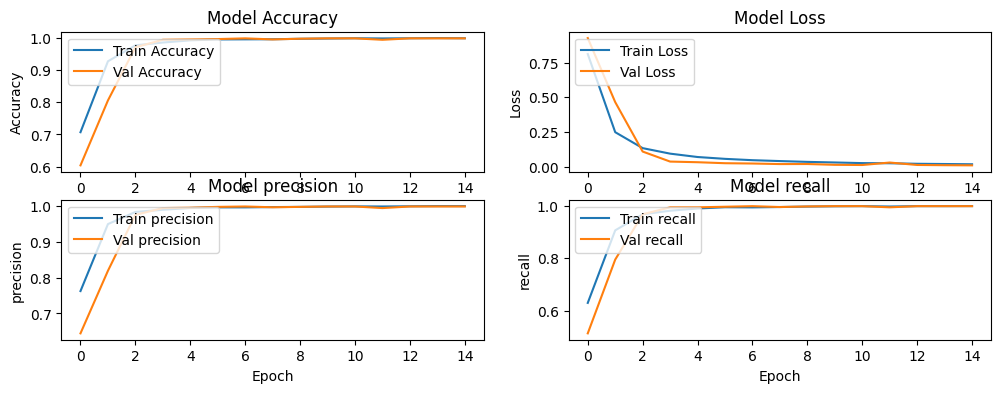

In [16]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

# Plot precision
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Train precision')
plt.plot(history.history['val_precision'], label='Val precision')
plt.title('Model precision')
plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend(loc='upper left')

# Plot recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Train recall')
plt.plot(history.history['val_recall'], label='Val recall')
plt.title('Model recall')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.legend(loc='upper left')

plt.show()

In [17]:
test_labels = y_test
len(test_labels)

1127

In [18]:
preds = model.predict(X_test,verbose=0)

In [19]:
cm = confusion_matrix(y_true = y_test.argmax(axis=1), y_pred = preds.argmax(axis=1))
cm

array([[325,   1,   0,   2],
       [  0, 227,   0,   0],
       [  0,   0, 282,   2],
       [  2,   0,   2, 284]])

In [20]:
loss, accuracy, recall, pre = model.evaluate(X_test,y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}, recall: {recall}, precision: {pre}')

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9905 - loss: 0.0218 - precision: 0.9905 - recall: 0.9905
Loss: 0.023806458339095116, Accuracy: 0.9920141696929932, recall: 0.9920141696929932, precision: 0.9920141696929932
